# Conditional Variational Autoencoder on the MNIST Dataset

## Imports and Constants

In [1]:
from keras import backend as K
from keras import layers as L
from keras import losses
from keras.datasets import mnist
from keras.models import Model

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

MNIST_RESOLUTION = 28

/home/ubuntu/git_repos/autoencoders-are-cool/.tox/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model Definitions

In [2]:
# hyperparameters
batch_size = 1000
latent_dim = 2
hidden_dim = 500
embedding_dim = 7

# encoder
image_input = L.Input(shape=(MNIST_RESOLUTION, MNIST_RESOLUTION))
flat_image = L.Flatten()(image_input)

label_input = L.Input(shape=(1,))
label_embedding = L.Embedding(
    name='label_embedding',
    input_dim=10,
    output_dim=embedding_dim)(label_input)
flat_embedding = L.Flatten()(label_embedding)

full_input = L.Concatenate()([flat_image, flat_embedding])

def make_dense_layer(inputs, name, size=hidden_dim, activation='relu'):
    batch_norm = L.BatchNormalization(name=f'{name}_batch_norm')(inputs)
    dense = L.Dense(name=f'{name}_dense', units=size,
                     activation=activation)(batch_norm)
    return dense

h1 = make_dense_layer(name='h1', inputs=full_input)

mean = make_dense_layer(name='mean', inputs=h1,
                        size=latent_dim, activation=None)
log_variance = make_dense_layer(name='log_variance', inputs=h1,
                                size=latent_dim, activation=None)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

sampling_input = L.Lambda(sampling, output_shape=(latent_dim,))([mean, log_variance])

full_decoder_input = L.Concatenate()([sampling_input, flat_embedding])

def make_decoder(inputs, name):
    h4 = make_dense_layer(name=f'{name}_h4', inputs=inputs)
    flat_output = make_dense_layer(name=f'{name}_output', inputs=h4,
                              size=MNIST_RESOLUTION * MNIST_RESOLUTION,
                              activation='sigmoid')
    image_output = L.Reshape((MNIST_RESOLUTION, MNIST_RESOLUTION))(flat_output)
    return image_output

image_output = make_decoder(full_decoder_input, 'connected')

def vae_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.sum(1 + log_variance - K.square(mean) - K.exp(log_variance), axis=-1)
    reconstruction_loss = MNIST_RESOLUTION * MNIST_RESOLUTION *\
            K.mean(losses.binary_crossentropy(image_input, image_output), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

vae = Model(inputs=[image_input, label_input], outputs=image_output)
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
label_embedding (Embedding)     (None, 1, 7)         70          input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_2 

## Training the Autoencoder

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
def fit(lr=0.001, num_epochs=5):
    K.set_value(vae.optimizer.lr, lr)
    vae.fit(x=[x_train, y_train], y=x_train,
        shuffle=True,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=([x_test, y_test], x_test),
        verbose=1)
    
def multi_fit(*pairs):
    for lr, num_epochs in pairs:
        print(f"\nSetting learning rate to {lr} for {num_epochs} epochs.")
        fit(lr=lr, num_epochs=num_epochs)

In [5]:
multi_fit((0.00001, 4),
          (0.0008, 5), (0.0025, 1),
          (0.0008, 5), (0.0025, 1),
          (0.0008, 5), (0.0025, 1),
          (0.0008, 5), (0.0025, 1),
          (0.0008, 5), (0.0025, 1),
          (0.0008, 5),
          (0.0001, 10))


Setting learning rate to 1e-05 for 4 epochs.
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s 23us/step - loss: 612.0947 - val_loss: 587.9962
Epoch 2/4
60000/60000 [==============================] - 1s 13us/step - loss: 589.9929 - val_loss: 580.1653
Epoch 3/4
60000/60000 [==============================] - 1s 13us/step - loss: 584.1888 - val_loss: 570.5809
Epoch 4/4
60000/60000 [==============================] - 1s 14us/step - loss: 572.3242 - val_loss: 565.0177

Setting learning rate to 0.0008 for 5 epochs.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 14us/step - loss: 445.2659 - val_loss: 258.2063
Epoch 2/5
60000/60000 [==============================] - 1s 14us/step - loss: 182.7915 - val_loss: 162.8095
Epoch 3/5
60000/60000 [==============================] - 1s 14us/step - loss: 157.2639 - val_loss: 154.4569
Epoch 4/5
60000/60000 [============================

## Plotting the Results

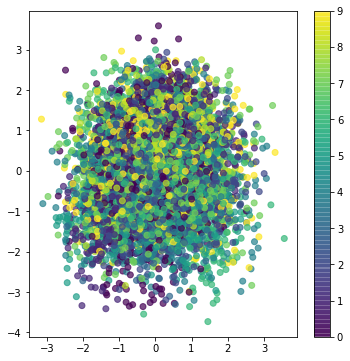

In [6]:
# plot latent/hidden space
import matplotlib.pyplot as plt

encoder = Model([image_input, label_input], mean)

# display a 2D plot of the digit classes in the latent space
means = encoder.predict([x_test, y_test], batch_size=batch_size)

f = plt.figure(figsize=(6, 6))
plt.scatter(means[:, 0], means[:, 1], c=y_test, alpha=0.7)
plt.colorbar()
plt.show()

In [7]:
# build a decoder that can sample from the latent space
decoder_input = L.Input(shape=(latent_dim,))
full_decoder_input = L.Concatenate()([decoder_input, flat_embedding])

image_output_ = make_decoder(inputs=full_decoder_input, name='generator')
x = vae.get_layer('connected_h4_batch_norm')(full_decoder_input)
x = vae.get_layer('connected_h4_dense')(x)
x = vae.get_layer('connected_output_batch_norm')(x)
x = vae.get_layer('connected_output_dense')(x)
x = L.Reshape((MNIST_RESOLUTION, MNIST_RESOLUTION))(x)

decoder = Model([decoder_input, label_input], x)
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
label_embedding (Embedding)     (None, 1, 7)         70          input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 7)            0           label_embedding[0][0]            
__________________________________________________________________________________________________
concatenat

In [8]:
from scipy.stats import norm
import numpy as np

def plot(label=1, n=4):
    figure = np.zeros((MNIST_RESOLUTION * n,) * 2)
    
    # Pick points spread across the range of the latent space
    grid_x = norm.ppf((np.polynomial.legendre.leggauss(n)[0] + 1)/2)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, np.array([label])])
            figure[i * MNIST_RESOLUTION: (i + 1) * MNIST_RESOLUTION,
                   j * MNIST_RESOLUTION: (j + 1) * MNIST_RESOLUTION] = x_decoded[0]
            

    plt.figure(figsize=(8, 8))
    plt.imshow(figure, cmap='Greys_r')
    
    ticks = np.linspace(0 + MNIST_RESOLUTION/2, MNIST_RESOLUTION * n - MNIST_RESOLUTION/2, n)
    plt.xticks(ticks, ["%1.1f" % x  for x in grid_x])
    plt.xlabel("Mean Parameter 1")
    
    plt.yticks(ticks, ["%1.1f" % x  for x in grid_x])
    plt.ylabel("Mean Parameter 2")
    
    plt.show()

In [9]:
from ipywidgets import interact
import ipywidgets as widgets

interact(plot, label=widgets.IntSlider(min=0, max=9, step=1, value=7));

interactive(children=(IntSlider(value=7, description='label', max=9), IntSlider(value=4, description='n', max=12, min=-4), Output()), _dom_classes=('widget-interact',))